# OpenStreetMap: Puntos de Interés

En este ejercicio complementaremos lo que vimos en el ejercicio anterior. Esta vez nos enfocaremos en los **Puntos de Interés**, Points of Interest en inglés. 

La [definición que da Wikipedia](https://es.wikipedia.org/wiki/Punto_de_inter%C3%A9s) es la siguiente:

> Un **punto de interés** o **"PDI"** (en inglés **_POI_**), es un punto de ubicación específica que alguien puede encontrar útil o interesante. Un ejemplo es un punto de la Tierra que representa la ubicación de edificios, un punto en Marte que representa la ubicación de la montaña el Monte Olimpo. La mayoría de los usuarios utilizan el término para referirse a hoteles, campings, estaciones de servicio, radares o cualquier otras categorías utilizadas en los modernos Sistema de navegación para automóviles.

> El término se utiliza ampliamente en la cartografía, en particular en las variantes electrónicas incluyendo SIG, y software de navegación GPS. En este contexto, es sinónimo de waypoint.

> Un punto de interés GPS precisa, como mínimo, latitud y longitud del PDI, asumiendo un cierto datos de mapas. Un nombre o una descripción para el PDI se suele incluir, además de otra información como la altitud o un número de teléfono también puede adjuntarse. Aplicaciones GPS suelen utilizar iconos para representar las diferentes categorías de PDI en el mapa de forma gráfica.

El propósito de este notebook es poder visualizar los POIs que haya en alguna comuna del país, de acuerdo a los datos que tiene **OpenStreetMap**. Para lograrlo debemos:

  1. Bajar los datos necesarios.
  2. Procesar el contenido de los datasets para obtener los POIs.
  3. Filtrar los POIs que pertenecen a la comuna.
  4. Visualizarlos.
  
A medida que vayamos ejecutando código aparecerán conceptos de programación como _funciones_ y _callbacks_, _objetos_, _excepciones_, _estructuras de datos_, entre otros.

## Datos Necesarios

Usaremos dos fuentes de datos:

  1. Los datos de OpenStreetMap (OSM) para Chile. Fueron bajados desde  [GeoFabrik](http://download.geofabrik.de/south-america/chile.html), en particular el fichero ```chile-latest.osm.pbf``` generado en ```2017-08-13T20:44:02Z```. 
  
  Este archivo está en un formato llamado ProtoBuf que podemos leer con la biblioteca ```imposm.parser```. La biblioteca está en la misma carpeta que este notebook. Fue bajada de [este repositorio en github](https://github.com/mtskelton/imposm-parser).

  2. Los bordes administrativos de las comunas de Chile en formato Shapefile (```shp```). Fueron bajados desde la página de la [Biblioteca del Congreso Nacional, sección Mapas Vectoriales](https://www.bcn.cl/siit/mapas_vectoriales/index_html). 
  
Si utilizas Mac o Ubuntu, el siguiente comando mostrará lo que hay dentro de la carpeta ```input```:

In [1]:
!ls -lh input

total 120M
-rw-rw-r-- 1 egraells egraells 120M ago 12 17:48 chile-latest.osm.pbf
drwxrwxrwx 2 egraells egraells 4,0K ago 14 19:49 shapefile_comunas


In [2]:
!ls -lh input/shapefile_comunas

total 45M
-rw-rw-r-- 1 egraells egraells 1001 ene 24  2011 Disclaimer.txt
-rw-rw-r-- 1 egraells egraells  58K mar 18  2014 division_comunal.dbf
-rw-rw-r-- 1 egraells egraells  409 ene 24  2011 division_comunal.prj
-rw-rw-r-- 1 egraells egraells 3,3K mar 18  2014 division_comunal.sbn
-rw-rw-r-- 1 egraells egraells  220 mar 18  2014 division_comunal.sbx
-rw-rw-r-- 1 egraells egraells  45M mar 18  2014 division_comunal.shp
-rw-rw-r-- 1 egraells egraells  18K ene 24  2011 division_comunal.shp.xml
-rw-rw-r-- 1 egraells egraells 2,9K mar 18  2014 division_comunal.shx


## Proceso de Datos para Obtener POIs

Utilizaremos la biblioteca [imposm.parser](https://imposm.org/docs/imposm.parser/latest/concepts.html) para leer el archivo de datos de OpenStreetMap. Ahora bien, no utilizamos la versión oficial, porque solamente funciona en Python 2, y nosotros utilizamos Python 3. Hemos incorporado la versión que usamos en la carpeta de este notebook.

In [3]:
from imposm.parser import OSMParser

Del módulo imposm.parser estamos importando la clase OSMParser. A diferencia de una función, que se puede llamar directamente desde nuetro código, una clase debe ser **instanciada**. Para instanciar una clase uno llama a su **constructor**, que es una función de la clase, y que instancia la clase a través de un **objeto**, que es el que queda asignado por la variable que decidamos.

Los objetos tienen funciones propias. Si la variable a es un objeto, y tiene una función o método f, entonces esa función se ejecuta en el código como a.f(). Por supuesto, f puede recibir parámetros (o no hacerlo), como cualquier función.

En el caso de OSMParser, esta clase define una función parse_pbf_file, que recibe como parámetro el nombre del archivo a procesar.


```python
parser = OSMParser()
parser.parse_pbf_file('./input/chile-latest.osm.pbf')
```

Pero las cosas no son tan fáciles.

Háganse la siguiente pregunta: ¿Qué haré con los datos?

La clase OSMParser no lo sabe. Por eso uno no "carga" el dataset con OSMParser, sino que **itera** sobre él. Y la manera de decirle qué es lo que queremos es a través de una **callback**. Como su nombre lo dice, es una llamada a función que se ejecuta en un instante definido.

Estamos interesados en los POIs de OpenStreetMap. De acuerdo a su documentación, los POIs son datos de tipo [Nodo](https://wiki.openstreetmap.org/wiki/Node) en OSM, donde también hay Caminos y Relaciones. Esos tres tipos de elementos en OSM permiten que se pueda especificar cualquier tipo de elemento que se despliega cartográficamente.

Como OSMParser lee todo el archivo que le entreguemos, es posible que se demore algunos minutos en trabajar. De momento no sabemos qué es lo que tiene este archivo, por lo que haremos lo siguiente: leeremos los primeros nodos que encontremos en el archivo, y luego abortaremos la ejecución. 

Para ello aprovecharemos las **excepciones**. Una excepción es una situación especial que sucede en un programa, que indica que ha sucedido un error, una situación excepcional.

### Ejemplo de Excepciones

Un ejemplo básico es tratar a una letra como un número:

In [4]:
prueba = int('a')

ValueError: invalid literal for int() with base 10: 'a'

Lo anterior ha resultado en una excepción que ha sido elevada desde la función int. 

Nosotros también podemos elevar excepciones:

In [7]:
def cancion_mala():
    print('esta cancion...')
    raise Exception('es mala, pero es mía')
    
cancion_mala()

esta cancion...


Exception: es mala, pero es mía

Cuando se eleva una excepción, el programa se interrumpe. Ahora bien, usualmente los programas no se caen. ¿Es que no ocurren excepciones?

No. Siempre suceden, sobretodo cuando estamos trabajando con datos. Suele pasar que las cosas no pasan como nosotros queremos que pasen. 

Que una situación sea excepcional no significa que no se pueda preveer. Y eso es lo que se hace en el código para poder continuar la ejecución después de una excepción.

Eso se hace a través de la instrucción try:

In [8]:
try:
    cancion_mala()
    print('... es mala, pero es mía')
except:
    print('... cri cri ...')

esta cancion...
... cri cri ...


Lo que ha sucedido es: se comenzó a ejecutar la función cancion\_mala, pero se interrumpió la ejecución debido a la excepción. Por tanto, se continuó ejecutando lo que estaba en el bloque except.

Usaremos excepciones para poder _intrusear_  lo que tiene el archivo de OSM.

### Procesando el Fichero PBF

La documentación de imposm.parser indica que el constructor de la clase recibe un parámetro relevante para nosotros: nodes\_callback. Aquí también utilizamos el parámetro concurrency, pero de momento asumiremos que no es importante.

Así, la siguiente celda instancia OSMParser con un callback que recibe una lista de nodos, imprimie la información del primero de ellos, y luego eleva una excepción:

In [10]:
def poi_callback(list_of_nodes):
    if not list_of_nodes:
        return
    
    for node_info in list_of_nodes:
        print(node_info)
        raise Exception('Solamente estamos probando cómo funciona esto :)')

parser = OSMParser(nodes_callback=poi_callback, concurrency=1)
parser.parse_pbf_file('./input/chile-latest.osm.pbf')

(386138, {'highway': 'traffic_signals'}, (-70.64623270000001, -33.4428967))


Exception: Solamente estamos probando cómo funciona esto :)

Process Process-2:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/egraells/.virtualenvs/jupyter/lib/python3.5/site-packages/imposm/parser/simple.py", line 113, in parse_it
    parser.parse(input)
  File "/home/egraells/.virtualenvs/jupyter/lib/python3.5/site-packages/imposm/parser/pbf/multiproc.py", line 70, in parse
    pos_queue.put(pos)
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 294, in put
    if not self._sem.acquire(block, timeout):
KeyboardInterrupt


¿Qué pasó?

  * Se definió la callback.
  * Se instanció OSMParser.
  * Se empezó a procesar el archivo.
  * El parser llamó a la callback con una lista de nodos.
  * La callback imprimió la información del primer nodo:
    
    ```
    (89678636, {'created_by': 'JOSM'}, (-69.17035, -55.41813990000001))
    ```
    
    Es una tupla de tres elementos:
      * ID: 89552555
      * Diccionario de atributos: {'created_by': 'JOSM'}
      * Coordenadas: (-66.87836010000001, -55.337230000000005)
    
  * La callback elevó una excepción.
  * El parser interrumpió su ejecución.
  * Python explica dónde se elevó la excepción y cómo se llegó a ese punto. Esto se llama **[stack trace](https://en.wikipedia.org/wiki/Stack_trace)**.
  
Un nodo que solamente dice quién lo creo no nos sirve. Lo que queremos son los POIs en la ciudad. De acuerdo a la documentación, los nodos pueden tener tags (etiquetas). Estos tags debiesen aparecer en el diccionario de atributos.

Haremos dos cosas. Primero, nos fijaremos en el primer nodo que tenga más de un atributo, para saber qué contienen. Segundo, haremos try y except para capturar la excepción y evitar la interrupción del programa.

In [11]:
def poi_callback(list_of_nodes):
    if not list_of_nodes:
        return
    
    for node_info in list_of_nodes:
        if len(node_info[1]) > 1:
            print(node_info)
            raise Exception('Veamos qué pasa si buscamos nodos con más de un atributo :)')

try:
    parser = OSMParser(nodes_callback=poi_callback)
    parser.parse_pbf_file('./input/chile-latest.osm.pbf')
except:
    pass

(386157, {'highway': 'traffic_signals', 'traffic_signals': 'signal'}, (-70.65838920000002, -33.4369834))


Process Process-3:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/egraells/.virtualenvs/jupyter/lib/python3.5/site-packages/imposm/parser/simple.py", line 113, in parse_it
    parser.parse(input)
  File "/home/egraells/.virtualenvs/jupyter/lib/python3.5/site-packages/imposm/parser/pbf/multiproc.py", line 70, in parse
    pos_queue.put(pos)
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 294, in put
    if not self._sem.acquire(block, timeout):
KeyboardInterrupt


¡Eh! Encontramos un nodo que tiene dos atributos:

```python
{'traffic_signals': 'signal', 'highway': 'traffic_signals'}
```

Un diccionario tiene llaves y valores. Aquí las llaves son ```traffic_signals``` y ```highway```. En la documentación de OpenStreetMap existe una página [Map Features](https://wiki.openstreetmap.org/wiki/Map_Features) que explica el significado de cada par (llave, valor).  Si buscamos en la página, vemos que no aparece ```traffic_signals``` como llave, sino que solamente ```highway```. Esto significa que esta última es la llave primaria, la más importante. Y, para ese caso, la definición es:

> Lights that control the traffic

Es decir, semáforos. Pero hay muchos tipos de semáforo, y por eso existe la llave secundaria ```traffic_signals```: para especificar el tipo de semáforo. En este caso simplemente es un semáforo genérico, pero existen otros valores posibles, que podríamos encontrar más adelante. De momento lo que nos interesa es la clasificación primaria.

### Contando Nodos

Hagamos un experimento: leamos los primeros 1000 POIs y veamos qué son. Para esto simplemente contaremos las llaves que tienen, sin fijarnos en su posición o ID.

Sin embargo, aquí ya no podemos utilizar una función que haga esto de manera directa. Como queremos contar y guardar elementos, necesitamos una estructura que nos ayude a hacerlo llevando la cuenta de cuántos nodos hemos leído y cuáles han sido sus atributos. Para ello utilizaremos **clases**.

In [17]:
class Persona(object):
    # cada instancia de esta clase va a tener estas dos variables
    nombre = 'N.N.'
    edad = 0
    
    # cada función dentro de una clase recibe mínimo un parámetro. El primero, llamado self,
    # es la instancia de la clase. Por eso dentro de la función la variable self.nombre
    # se refiere al nombre de esta instancia de Persona.
    # La función __init__ define al constructor. Cuando instanciamos una persona queremos que
    # tenga nombre y edad. El constructor simplemente copia esos valores dentro de sus 
    # variables internas. Podría hacer otras cosas, por ejemplo, validar que sea una edad correcta.
    def __init__(self, nombre, edad):
        self.nombre = nombre
        self.edad = edad
        
    # Este método hace que la persona se presente. Lo hace imprimiendo un string con su nombre y edad.
    def presentacion(self):
        print('¡Hola! Me llamo {0} y tengo {1} años'.format(self.nombre, self.edad))
        
alguien = Persona('Ana Tijoux', 40)
alguien.presentacion()

¡Hola! Me llamo Ana Tijoux y tengo 40 años


Considerando lo anterior, Definiremos una **clase** que llamaremos ```NodeCounter``` y que instanciaremos en la variable ```node_counter```. Si saben de programación orientada a objetos reconocerán lo que está sucediendo. Si no, les recomiendo leer [este tutorial en castellano](http://pitando.net/2016/04/14/python-y-programacion-orientada-a-objetos/).

Para poder hacer lo que queremos, el contador de nodos debe hacer dos cosas:

  1. Llevar la cuenta de cuántos nodos ha leído. Si queremos leer solamente 1000, tenemos que poder decir "hemos leído 500."
  2. Llevar un contador de llaves. Para esto utilizaremos la la clase ```Counter``` que está en el módulo ```collections``` de Python. Esta clase tiene un método llamado ```update``` que recibe una lista de elementos, los cuenta, y va guardando la cantidad de elementos que ha visto.

Por ejemplo, el siguiente código crea una lista de números y luego cuenta cuántos hay:

In [18]:
from collections import Counter

numeros = [1,2,3,3,4,5,6,6,6,7]
counter = Counter()
counter.update(numeros)
counter

Counter({1: 1, 2: 1, 3: 2, 4: 1, 5: 1, 6: 3, 7: 1})

Noten que el contador es un diccionario. Y, por ejemplo, su llave ```6``` tiene valor ```3```: esto significa que el número 6 aparece 3 veces en la lista.

Al fin estamos listos para definir y utilizar el NodeCounter. 

Lo único que falta saber es cómo vamos a contar los atributos de cada nodo, o mejor dicho, como le decimos al Counter que se fije en las llaves del diccionario de atributos. Lo que debemos hacer es entregar al contador la lista de llaves, que obtenemos con el método ```keys()``` del diccionario:

In [22]:
class NodeCounter(object):
    key_counts = Counter()
    read_nodes = 0
    
    # NOTA: hemos omitido el constructor porque no lo necesitamos.

    def poi_callback(self, list_of_nodes):
        if not list_of_nodes:
            return

        for node_info in list_of_nodes:
            if len(node_info[1]) > 1:
                self.key_counts.update(node_info[1].keys())
                self.read_nodes += 1

                if self.read_nodes > 1000:
                    raise Exception('Ya leímos 1000 nodos :)')

                    
node_counter = NodeCounter()

try:
    parser = OSMParser(nodes_callback=node_counter.poi_callback, concurrency=1)
    parser.parse_pbf_file('./input/chile-latest.osm.pbf')
except:
    pass

# aquí accedemos a la variable key_counts del node_counter y le pedimos que ejecute su método most_common
node_counter.key_counts.most_common(50)

[('name', 885),
 ('source', 796),
 ('place', 771),
 ('is_in', 619),
 ('is_in:country', 258),
 ('is_in:region', 205),
 ('is_in:province', 197),
 ('is_in:municipality', 196),
 ('is_in:continent', 166),
 ('highway', 109),
 ('traffic_signals', 87),
 ('is_in:state', 85),
 ('capital', 77),
 ('ele', 76),
 ('ref', 61),
 ('natural', 60),
 ('is_in:country_code', 53),
 ('historic', 37),
 ('source_ref', 35),
 ('wikidata', 31),
 ('wikipedia', 29),
 ('material', 26),
 ('name:ru', 21),
 ('alt_name', 19),
 ('created_by', 14),
 ('population', 12),
 ('amenity', 10),
 ('start_date', 9),
 ('name:uk', 8),
 ('type', 7),
 ('height', 7),
 ('name:en', 6),
 ('restriction:conditional', 6),
 ('is_in:region_code', 5),
 ('is_in:state_code', 5),
 ('old_name', 5),
 ('volcano:type', 4),
 ('volcano:status', 4),
 ('name:he', 3),
 ('addr:city', 2),
 ('image', 2),
 ('landuse', 2),
 ('addr:postcode', 2),
 ('exit_to', 2),
 ('short_name', 2),
 ('addr:street', 2),
 ('proposed:capital', 2),
 ('name:fr', 2),
 ('hour_off', 2),
 

Process Process-7:
  File "/home/egraells/.virtualenvs/jupyter/lib/python3.5/site-packages/imposm/parser/simple.py", line 113, in parse_it
    parser.parse(input)
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/egraells/.virtualenvs/jupyter/lib/python3.5/site-packages/imposm/parser/pbf/multiproc.py", line 70, in parse
    pos_queue.put(pos)
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 294, in put
    if not self._sem.acquire(block, timeout):
KeyboardInterrupt


De los 1000 nodos, 885 tienen un nombre, 796 tienen una fuente, y 109 son del tipo ```highway``` (que ya habíamos comentado). Hay atributos que agregan meta-datos, como ```is_in:municipality```, otros que indican si es un punto de interés histórico (```historic```), y otros que son estaciones de algún modo de transporte (```station```), entre otros.

Ahora procedamos a almacenar esta información en un DataFrame. Un DataFrame es una tabla, como una base de datos o una hoja de cálculo. Así, haremos lo siguiente:

  * Cargaremos los primeros 1000 nodos y los guardaremos en un DataFrame. Cada fila del dataframe será un punto de interés, y cada columna una de las llaves que se definen en el archivo.
  * Cuando leamos un nodo vamos a unificar sus atributos en un único diccionario que tenga tanto los tags de OpenStreetMap como su ID.

In [23]:
class NodeCounter(object):
    pois = []
    read_nodes = 0
    

    def poi_callback(self, list_of_nodes):
        if not list_of_nodes:
            return

        for node_info in list_of_nodes:
            if len(node_info[1]) > 1:
                poi = dict(node_info[1])
                poi['id'] = node_info[0]
                
                self.pois.append(poi)
                self.read_nodes += 1

                if self.read_nodes > 1000:
                    raise Exception('Ya leímos 1000 nodos :)')

node_counter = NodeCounter()

try:
    parser = OSMParser(nodes_callback=node_counter.poi_callback, concurrency=1)
    parser.parse_pbf_file('./input/chile-latest.osm.pbf')
except:
    pass

Process Process-8:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/egraells/.virtualenvs/jupyter/lib/python3.5/site-packages/imposm/parser/simple.py", line 113, in parse_it
    parser.parse(input)
  File "/home/egraells/.virtualenvs/jupyter/lib/python3.5/site-packages/imposm/parser/pbf/multiproc.py", line 70, in parse
    pos_queue.put(pos)
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 294, in put
    if not self._sem.acquire(block, timeout):
KeyboardInterrupt


In [24]:
import pandas as pd

dataframe_pois = pd.DataFrame.from_records(node_counter.pois)
dataframe_pois.head(5)

,FIXME,addr:city,addr:country,addr:housenumber,addr:postcode,addr:street,admin_level,alt_name,alt_name_1,amenity,...,type,volcano:last_eruption,volcano:status,volcano:type,website,wheelchair,wikidata,wikipedia,wikipedia:de,wikipedia:en
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Le hemos pedido al DataFrame que nos muestre las primeras cinco filas. Efectivamente, aparecen cinco filas, y cada columna parece ser uno de los tags que tenían los nodos de acuerdo a lo que vimos antes. Sin embargo, solamente vemos NaN como valor en cada celda del DataFrame. ¿Por qué?

```NaN``` significa _Not a Number_, y es utilizado para indicar que no hay un número o bien hay un valor nulo o inexistente en esa celda. Esto se debe a que potencialmente hay cientos de columnas (las etiquetas de OSM), pero cada nodo solamente tiene unas cuantas etiquetas definidas. 

Para poder explorar el DataFrame podemos realizar consultas. Por ejemplo, si queremos ver las filas que son estaciones de transporte, entonces deberíamos encontrar aquellas cuya columna ```station``` no sea nula o ```NaN```. Para ello nos apoyaremos en la función ```isnull``` de ```pandas```.

Para ver solamente una columna, tratamos al DataFrame como si fuera un diccionario. Por cierto, el método ```head(n)```, que entrega las primeras $n$ filas del DataFrame, también es un DataFrame. 

In [32]:
dataframe_pois.head(5)['amenity']

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: amenity, dtype: object

Lo anterior muestra solamente la columna ```station``` del DataFrame ```dataframe_pois.head(5)```. Si no utilizamos ```head(5)```, entonces nos mostraría la columna completa, que es de un tamaño considerable.

El método ```isnull``` de pandas recibe un DataFrame o una columna. Por tanto, podemos hacer lo siguiente:

In [33]:
pd.isnull(dataframe_pois.head(5)['amenity'])

0    True
1    True
2    True
3    True
4    True
Name: amenity, dtype: bool

Nos dice que las primeras cinco filas tienen valor nulo en la columna ```station```.

Ahora bien, **sabemos** que hay filas donde la columna ```station``` no es nula. Para eso utilizaremos el operador de consultas de pandas. Nos apoyaremos en el operador ```~```, que niega el resultado que recibe. 

In [34]:
~pd.isnull(dataframe_pois.head(5)['amenity'])

0    False
1    False
2    False
3    False
4    False
Name: amenity, dtype: bool

El operador ```[]``` de pandas permite obtener una columna si le entregamos un nombre (que ha sido ```station``` hasta ahora). Sin embargo, si le pasamos una serie de valores verdadero o falso, como el que acabamos de calcular, entonces recibiremos las filas del DataFrame en las cuales la serie es verdadera. Así:

In [35]:
dataframe_pois[~pd.isnull(dataframe_pois.amenity)]

,FIXME,addr:city,addr:country,addr:housenumber,addr:postcode,addr:street,admin_level,alt_name,alt_name_1,amenity,...,type,volcano:last_eruption,volcano:status,volcano:type,website,wheelchair,wikidata,wikipedia,wikipedia:de,wikipedia:en
159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ferry_terminal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,place_of_worship,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hospital,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ciudadano Restaurant,NaN,pub,...,NaN,NaN,NaN,NaN,http://www.ciudadanorestaurant.cl,NaN,NaN,NaN,NaN,NaN
175,NaN,Providencia,CL,1240,NaN,Santa Isabel,NaN,NaN,NaN,library,...,NaN,NaN,NaN,NaN,http://www.providencia-biblioteca.cl,NaN,NaN,NaN,NaN,NaN
178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,college,...,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,NaN
228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bus_station,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ferry_terminal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ferry_terminal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237,NaN,Puerto Varas,NaN,NaN,NaN,Del Salvador,NaN,NaN,NaN,fuel,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Obtuvimos 33 columnas. Por supuesto que nuevamente vemos muchos NaN. Sin embargo, estas filas tienen la columna ```station``` como no nula. Veamos lo que tienen. Para ello usaremos el operador ```[]``` dos veces. La primera vez para obtener el DataFrame de estaciones, y la segunda para ver el valor de la columna de interés.

In [36]:
stations = dataframe_pois[~pd.isnull(dataframe_pois.amenity)]
stations['amenity']

159      ferry_terminal
172    place_of_worship
173            hospital
174                 pub
175             library
178             college
228         bus_station
232      ferry_terminal
233      ferry_terminal
237                fuel
Name: amenity, dtype: object

Son todas estaciones de metro. Si vemos la documentación, notaremos que existe una columna ```name``` para muchos POIs. Veámosla:

In [37]:
stations['name']

159        Terminal Ferry Dalcahue
172         Madre Bernardita Morín
173                      Avansalud
174                  Bar Ciudadano
175    Café Literario Santa Isabel
178                        Duoc UC
228            Parada San Bernardo
232                Caleta La Arena
233                 Caleta Puelche
237                      Petrobras
Name: name, dtype: object

Tuvimos suerte, dentro de los primeros 1000 POIs que leímos había varias estaciones de metro :) 

¿Creen que este modo de proceder es el mejor? La respuesta depende de lo que queremos hacer. Por ejemplo, si lo que queremos es buscar tipos específicos de POIs, entonces quizás es mejor estrategia definir esa lista a priori y luego asegurarnos de leer solamente esos nodos.

En el ejercicio anterior utilizamos la biblioteca ```osmnx``` para descargar la red de transporte utilizando OpenStreetMap. Utilizando estas técnicas podríamos reconstruir esas redes, sin embargo, sería muy laborioso hacerlo.

Lo que no entrega ```osmnx``` es la lista de POIs. Eso lo recuperaremos ahora. Nos enfocaremos en las categorías que pueden ser relevantes para poner sobre el mapa, sin considerar la red de transporte. De acuerdo a la documentación, la siguiente es una lista blanca propuesta de llaves primarias:

In [84]:
whitelist = {'amenity', 'building', 'craft', 'emergency', 'historic', 'leisure', 'man_made', 
    'office', 'power', 'shop', 'sport', 'tourism', 'public_transport', 'railway',
    'military', 'natural', 'landmark'}

La variable ```whitelist``` es un **set**. Es como una lista, pero a diferencia de ésta, no tiene orden. Si la imprimimos ahora veremos que quizás no se ve igual como la definimos:

In [85]:
whitelist

{'amenity',
 'building',
 'craft',
 'emergency',
 'historic',
 'landmark',
 'leisure',
 'man_made',
 'military',
 'natural',
 'office',
 'power',
 'public_transport',
 'railway',
 'shop',
 'sport',
 'tourism'}

En efecto. ¿De qué sirve un set? Es un conjunto en el cual es muy rápido preguntar si un elemento se encuentra dentro, o bien para calcular intersecciones entre sets. Lo utilizaremos para definir cuáles nodos leer. Aprovecharemos también de quedarnos únicamente con el atributo ```name``` de los POIs.

In [86]:
class NodeCounter(object):
    pois = []
    read_nodes = 0
    whitelist = {}
    
    def __init__(self, whitelist):
        self.whitelist = whitelist

    def poi_callback(self, list_of_nodes):
        if not list_of_nodes:
            return

        for node_info in list_of_nodes:
            if len(node_info[1]) > 1:
                common_keys = list(self.whitelist.intersection(node_info[1].keys()))
                
                if common_keys:
                    poi = {
                        'id': node_info[0],
                        'key': common_keys[0],
                        'value': node_info[1][common_keys[0]],
                        'name': node_info[1]['name'] if 'name' in node_info[1] else None                        
                    }
                    
                    self.pois.append(poi)
                    
                self.read_nodes += 1

                if self.read_nodes > 1000:
                    raise Exception('Ya leímos 1000 nodos :)')

node_counter = NodeCounter(whitelist)

try:
    parser = OSMParser(nodes_callback=node_counter.poi_callback, concurrency=1)
    parser.parse_pbf_file('./input/chile-latest.osm.pbf')
except:
    pass

In [87]:
dataframe_pois = pd.DataFrame.from_records(node_counter.pois)
dataframe_pois.shape

(104, 4)

De todos los nodos, solamente 262 eran de los tipos que incluimos en la lista blanca.

In [88]:
dataframe_pois.sample(10)

,id,key,name,value
75,96305579,natural,Cerro Irpa,peak
64,96304735,natural,Cerro Chipapa,peak
35,96186827,natural,Cerro Vidal Gormaz,peak
52,96196534,historic,Hito II-IV Monte Dinero,boundary_stone
97,141096340,railway,Toesca,station
11,96182736,historic,Hito 26,boundary_stone
93,133350445,amenity,Avansalud,hospital
77,96305932,natural,None,peak
9,96182486,historic,Hito 42,boundary_stone
73,96305428,historic,Hito s/n-LXXVI,boundary_stone


Esto ya parece más útil. Ahora bien, lo que _realmente_ queremos son las coordenadas de cada POI, ¿no? Para eso necesitaremos usar un GeoDataFrame y el módulo ```shapely```

In [89]:
from shapely.geometry import Point
import geopandas as gpd

In [90]:
class NodeCounter(object):
    pois = []
    read_nodes = 0
    whitelist = {}
    
    def __init__(self, whitelist):
        self.whitelist = whitelist

    def poi_callback(self, list_of_nodes):
        if not list_of_nodes:
            return

        for node_info in list_of_nodes:
            if len(node_info[1]) > 1:
                common_keys = list(self.whitelist.intersection(node_info[1].keys()))
                if common_keys:
                    poi = {
                        'id': node_info[0],
                        'key': common_keys[0],
                        'value': node_info[1][common_keys[0]],
                        'name': node_info[1]['name'] if 'name' in node_info[1] else None,
                        'position': Point(node_info[2])
                    }
                    
                    #poi['geometry'] = Point(node_info[2])
                    self.pois.append(poi)
                    
                self.read_nodes += 1

                if self.read_nodes > 1000:
                    raise Exception('Ya leímos 1000 nodos :)')

node_counter = NodeCounter(whitelist)

try:
    parser = OSMParser(nodes_callback=node_counter.poi_callback, concurrency=1)
    parser.parse_pbf_file('./input/chile-latest.osm.pbf')
except:
    pass

In [91]:
dataframe_pois = gpd.GeoDataFrame(pd.DataFrame.from_records(node_counter.pois), 
                                  geometry='position', 
                                  crs={'init': 'epsg:4326'})
dataframe_pois.shape

(104, 5)

In [92]:
dataframe_pois.head()

,id,key,name,position,value
0,84204260,natural,Volcán Osorno,POINT (-72.49756940000012 -41.10418709999997),volcano
1,86637068,natural,Volcán Calbuco,POINT (-72.60982550000011 -41.32985159999993),volcano
2,89581069,natural,Pointe Noire,POINT (-69.35780489999996 -55.5549894),cape
3,96178518,historic,Hito Trifinio Bolivia - Chile - Perú,POINT (-69.4684824 -17.49839980000004),boundary_stone
4,96182306,historic,Hito 25,POINT (-69.98524689999999 -18.26978230000004),boundary_stone


In [93]:
%matplotlib inline

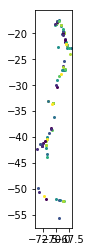

In [94]:
dataframe_pois.plot()

Ahora carguemos todos los POIs que vienen en el dataset.

In [95]:
class NodeCounter(object):
    pois = []
    whitelist = {}
    
    def __init__(self, whitelist):
        self.whitelist = whitelist

    def poi_callback(self, list_of_nodes):
        if not list_of_nodes:
            return

        for node_info in list_of_nodes:
            if len(node_info[1]) > 1:
                common_keys = list(self.whitelist.intersection(node_info[1].keys()))
                if common_keys:
                    poi = {
                        'id': node_info[0],
                        'key': common_keys[0],
                        'value': node_info[1][common_keys[0]],
                        'name': node_info[1]['name'] if 'name' in node_info[1] else None,
                        'position': Point(node_info[2])
                    }

                    self.pois.append(poi)

node_counter = NodeCounter(whitelist)
parser = OSMParser(nodes_callback=node_counter.poi_callback)
parser.parse_pbf_file('./input/chile-latest.osm.pbf')

In [96]:
dataframe_pois = gpd.GeoDataFrame(pd.DataFrame.from_records(node_counter.pois), geometry='position', 
                                  crs={'init': 'epsg:4326'})
dataframe_pois.shape

(68735, 5)

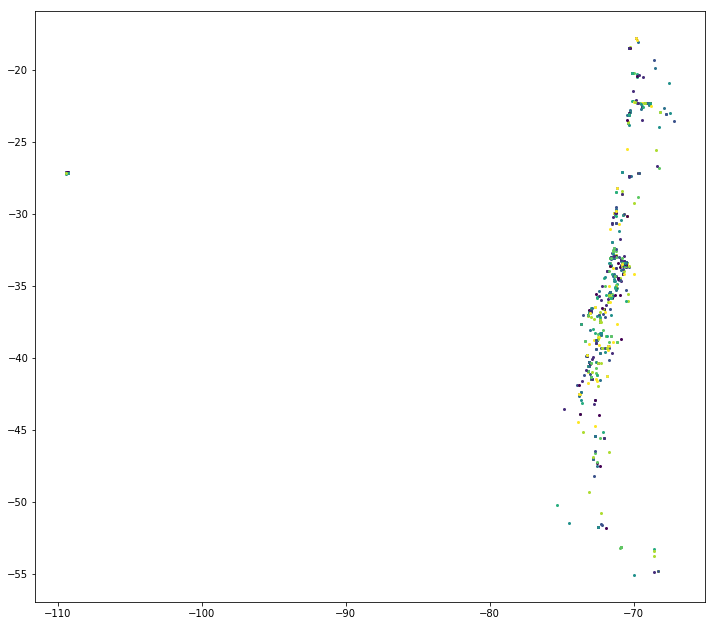

In [97]:
dataframe_pois.sample(1000).plot(figsize=(12,12))

¡Tenemos puntos en todo Chile, incluyendo Isla de Pascua! Y eso que solamente dibujamos una muestra.

## Eligiendo POIs de Acuerdo a su Ubicación

Es probable que en nuestros proyectos estemos interesados en alguna área en particular, o bien, que queramos asignar alguna zona específica a cada POI. Esta zona puede ser una zona de análisis de transporte, una comuna, una provincia, o una región.

Utilizaremos GeoPandas nuevamente para leer los bordes administrativos de las comunas y quedarnos solamente con los POIs de la Región Metropolitana.

In [56]:
municipalities = gpd.read_file('./input/shapefile_comunas',
                               crs={'init': 'epsg:5361'})

Hay algo distinto. Aquí le pedimos a GeoPandas (gpd) que lea un archivo (read_file), pero en realidad le pasamos una carpeta, y además el parámetro crs es distinto al que usamos antes. ¿Por qué? 

  1. Los ficheros Shapefile (.shp) se distribuyen en una carpeta, ya que contienen varios archivos auxiliares que también son necesarios.
  2. En este archivo particular se utiliza un sistema de coordenadas que no es el que uno esperaría, de (latitud,longitud). 
  
Lo referente al punto 2 se observa a continuación. La columna geometry contiene polígonos cuyos puntos tienen coordenadas que no se parecen en nada a las de los POIs de OSM.

In [60]:
municipalities.sample(5)

,CIR_SENA,COD_COMUNA,DIS_ELEC,NOM_COM,NOM_PROV,NOM_REG,SHAPE_Area,SHAPE_LENG,SHAPE_Le_1,geometry
0,14,9204,48,Ercilla,Malleco,Región de La Araucanía,4.979025e+08,170675.595438,170675.595706,"POLYGON ((190393.2198999999 5794527.3661, 1904..."
207,11,7408,39,Yerbas Buenas,Linares,Región del Maule,2.590269e+08,87657.194262,87657.194368,"POLYGON ((273125.8499999996 6056569.5152, 2733..."
142,12,8102,45,Coronel,Concepción,Región del Bío-Bío,2.787924e+08,127818.315587,127818.315541,"(POLYGON ((133684.0343000004 5906280.7296, 133..."
75,9,6204,35,Marchigüe,Cardenal Caro,Región del Libertador Bernardo O'Higgins,6.586934e+08,170038.624165,170038.623784,"POLYGON ((241952.0623000003 6211313.0038, 2420..."
243,1,1510,1,Camarones,Arica,Región de Arica y Parinacota,3.623947e+09,382307.008098,382307.007840,"POLYGON ((449601.0926000001 7932143.4981, 4500..."


Del mismo modo que antes podíamos filtrar el DataFrame de acuerdo a si un valor era nulo, ahora podemos filtrarlo de acuerdo a la región a la que pertenece cada fila.

In [61]:
municipalities.sample(15)['NOM_REG']

192                             Región del Maule
280                           Región del Bío-Bío
272                         Región de Valparaíso
171                           Región del Bío-Bío
325    Región de Aysén del Gral.Ibañez del Campo
195                             Región del Maule
343                         Región de Valparaíso
179             Región Metropolitana de Santiago
65      Región del Libertador Bernardo O'Higgins
227             Región Metropolitana de Santiago
148                           Región del Bío-Bío
229                           Región de Los Ríos
161                           Región del Bío-Bío
213                             Región del Maule
295             Región Metropolitana de Santiago
Name: NOM_REG, dtype: object

In [62]:
municipalities.sample(15)['NOM_REG'] == 'Región Metropolitana de Santiago'

101    False
130    False
112    False
340    False
109    False
236    False
184     True
283    False
249    False
345    False
238    False
148    False
174    False
118    False
171    False
Name: NOM_REG, dtype: bool

In [63]:
rm = municipalities[municipalities['NOM_REG'] == 'Región Metropolitana de Santiago']
rm.shape

(52, 10)

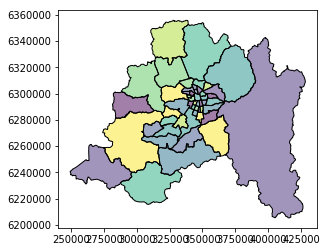

In [64]:
rm.plot()

Aquí se observa que efectivamente se utiliza un sistema de coordenadas diferente. Observen la magnitud de las coordenadas en comparación con las del gráfico de POIs.

¿Cómo situar ambos GeoDataFrames en el mismo sistema de coordenadas?

La respuesta es que debemos hacer que ambos GeoDataFrames utilicen la misma [_proyección cartográfica_](https://es.wikipedia.org/wiki/Proyecci%C3%B3n_cartogr%C3%A1fica). Afortunadamente GeoPandas permite convertir fácilmente de una proyección a otra.

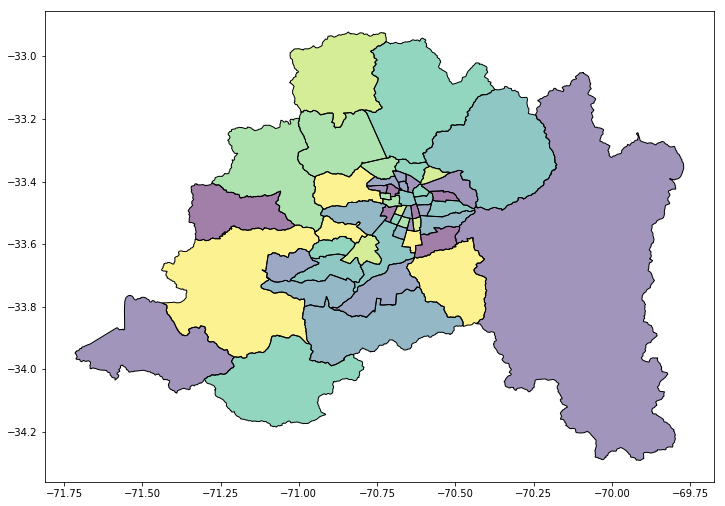

In [66]:
rm_lat_lon = rm.to_crs({'init': 'epsg:4326'})
rm_lat_lon.plot(figsize=(12,12))

Ahora sí :)

In [67]:
rm_lat_lon.sample(5)

,CIR_SENA,COD_COMUNA,DIS_ELEC,NOM_COM,NOM_PROV,NOM_REG,SHAPE_Area,SHAPE_LENG,SHAPE_Le_1,geometry
220,7,1330,16,Tiltil,Chacabuco,Región Metropolitana de Santiago,6.531615e+08,133827.265443,133827.265139,POLYGON ((-70.83450815402658 -32.9276435402422...
312,8,1311,25,Macul,Santiago,Región Metropolitana de Santiago,1.279411e+07,15200.750374,15151.816703,POLYGON ((-70.57681955294478 -33.4702656930307...
313,7,1311,20,Maipú,Santiago,Región Metropolitana de Santiago,1.380380e+08,61424.982526,61429.469836,POLYGON ((-70.76505155386489 -33.4592583707145...
184,8,1312,25,San Joaquín,Santiago,Región Metropolitana de Santiago,9.876877e+06,13987.326781,13986.827395,POLYGON ((-70.62341581773579 -33.4733797392914...
311,8,1311,23,Las Condes,Santiago,Región Metropolitana de Santiago,9.839607e+07,51230.563241,51374.349007,POLYGON ((-70.53235176218874 -33.3821684107016...


Ahora digamos que la Región Metropolitana quizás es demasiado grande para lo que queremos. Por ejemplo, podríamos estar interesados en una comuna particular. Veamos el caso de Santiago Centro.

In [70]:
stgo_centro = rm_lat_lon[rm_lat_lon['NOM_COM'] == 'Santiago']
stgo_centro

,CIR_SENA,COD_COMUNA,DIS_ELEC,NOM_COM,NOM_PROV,NOM_REG,SHAPE_Area,SHAPE_LENG,SHAPE_Le_1,geometry
305,7,1310,22,Santiago,Santiago,Región Metropolitana de Santiago,2.276999e+07,24644.018619,22142.660056,POLYGON ((-70.67158854755513 -33.4763598849684...


¿Cómo podemos obtener los POIs que están dentro de esta comuna?

La respuesta es: a través de la operación que GeoPandas define como [Spatial Join](https://pro.arcgis.com/en/pro-app/tool-reference/big-data-analytics/spatial-relationships-with-big-data.htm). Existen distintos tipos de _joins_ de acuerdo a las geometrías que usamos. Punto con Punto, Polígono con Polígono, Punto con Polígono, y distintas _operaciones_, como intersección, contenimiento, cercanía, etc.

Usemos la operación más básica, que consiste en obtener todos los POIs que están dentro del o los polígonos que nos interesan. Afortunadamente GeoPandas nos permite realizar esta operación de manera sencilla.

In [99]:
stgo_centro_pois = gpd.sjoin(dataframe_pois, stgo_centro, op='within')
stgo_centro_pois.sample(10)

KeyError: 'geometry'

Obtuvimos una excepción del tipo KeyError. Dice que la columna ```geometry``` no está en el GeoDataFrame de POIs. Es verdad: habíamos nombrado esa columna como ```coordinates```. Lamentablemente para GeoPandas es necesario llamar ```geometry``` a la columna espacial. Aún así, tenemos suerte: es muy fácil corregir este problema:

In [100]:
dataframe_pois.rename(columns={'position': 'geometry'}, inplace=True)

In [101]:
stgo_centro_pois = gpd.GeoDataFrame(gpd.sjoin(dataframe_pois, stgo_centro, op='within'))
stgo_centro_pois.sample(10)

,id,key,name,geometry,value,index_right,CIR_SENA,COD_COMUNA,DIS_ELEC,NOM_COM,NOM_PROV,NOM_REG,SHAPE_Area,SHAPE_LENG,SHAPE_Le_1
51486,4458492281,amenity,Minimas,POINT (-70.67380090000005 -33.45868230000004),nightclub,305,7,1310,22,Santiago,Santiago,Región Metropolitana de Santiago,2.276999e+07,24644.018619,22142.660056
51371,4455705039,shop,EQQUS,POINT (-70.67582520000026 -33.45416759999969),yes,305,7,1310,22,Santiago,Santiago,Región Metropolitana de Santiago,2.276999e+07,24644.018619,22142.660056
58222,4557987389,tourism,"Asilo de ancianos ""Nuevo amanecer""",POINT (-70.66165139999936 -33.47172210000001),guest_house,305,7,1310,22,Santiago,Santiago,Región Metropolitana de Santiago,2.276999e+07,24644.018619,22142.660056
53649,4463479630,shop,D yG Importaciones,POINT (-70.67617969999989 -33.45534830000028),yes,305,7,1310,22,Santiago,Santiago,Región Metropolitana de Santiago,2.276999e+07,24644.018619,22142.660056
49614,4443287190,shop,Erbi,POINT (-70.63523339999999 -33.44794739999993),convenience,305,7,1310,22,Santiago,Santiago,Región Metropolitana de Santiago,2.276999e+07,24644.018619,22142.660056
53903,4464140392,shop,Hyunkia,POINT (-70.64282719999952 -33.45315650000033),car_parts,305,7,1310,22,Santiago,Santiago,Región Metropolitana de Santiago,2.276999e+07,24644.018619,22142.660056
49990,4455249392,shop,Gmo,POINT (-70.64905859999958 -33.4416453000006),yes,305,7,1310,22,Santiago,Santiago,Región Metropolitana de Santiago,2.276999e+07,24644.018619,22142.660056
46297,4396815173,shop,Almacen,POINT (-70.66274769999971 -33.45590079999959),convenience,305,7,1310,22,Santiago,Santiago,Región Metropolitana de Santiago,2.276999e+07,24644.018619,22142.660056
55346,4473056254,shop,Milagro,POINT (-70.67518110000013 -33.45249399999997),yes,305,7,1310,22,Santiago,Santiago,Región Metropolitana de Santiago,2.276999e+07,24644.018619,22142.660056
52007,4466585935,amenity,Fuente de Soda La Curicana,POINT (-70.64742379999871 -33.44547849999999),cafe,305,7,1310,22,Santiago,Santiago,Región Metropolitana de Santiago,2.276999e+07,24644.018619,22142.660056


¿Qué sucedió? Obtuvimos como resultado las filas del GeoDataFrame de POIs cuya posición estaba dentro de los polígonos del GeoDataFrame de comunas de interés (que en este caso era una). Además, esas filas tienen **nuevas columnas**: las correspondientes a las de los polígonos a las que pertenecían.

Ahora dibujemos estos POIs:

In [102]:
stgo_centro_pois.shape

(3348, 15)

In [103]:
stgo_centro_pois.value.value_counts()

yes                                   606
restaurant                            360
pharmacy                              157
convenience                           154
bank                                  140
car_parts                             129
cafe                                  116
school                                107
fast_food                              97
alcohol                                64
hotel                                  58
subway_entrance                        51
company                                49
clothes                                47
kindergarten                           47
parking                                38
bakery                                 34
bicycle_parking                        33
optician                               32
supermarket                            31
government                             31
atm                                    30
hairdresser                            26
books                             

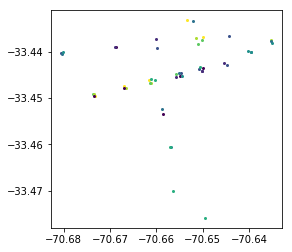

In [116]:
relevant_pois = stgo_centro_pois[stgo_centro_pois.value == 'subway_entrance']
relevant_pois.plot()

Digamos que queremos visualizar las entradas de metro en un mapa interactivo que nos entregue contexto.

In [104]:
import folium

Centraremos el mapa en el centroide geométrico de la comuna de Santiago. Utilizaremos el atributo ```centroid``` que tiene cada instancia de un GeoDataFrame. Lo que hace es entregar el centroide de cada fila.

In [106]:
centroid = stgo_centro.centroid
centroid

305    POINT (-70.65641338735794 -33.45353958456027)
dtype: object

Aunque estamos trabajando con un GeoDataFrame que tiene un solo elemento, la variable centroid sigue teniendo una serie. Observamos que el identificador del centroide es 305, por lo que podemos acceder a él haciendo lo siguiente:

In [112]:
centroid_position = centroid[305]

In [113]:
centroid_position.x, centroid_position.y

(-70.65641338735794, -33.453539584560275)

Creamos el mapa con folium. Noten que folium pide como ubicación latitud (y) y longitud (x), por lo que debemos entregarle los parámetros al revés de lo que esperaríamos.

In [115]:
stgo_map = folium.Map(location=[centroid_position.y, centroid_position.x], zoom_start=12)
#las_condes_map

Bien, tenemos un mapa. Ahora queremos que cada POI tenga un marcador con su nombre. ¿Cómo lo hacemos? Para eso necesitamos **iterar** sobre el GeoDataFrame.

In [118]:
for idx, poi in relevant_pois.iterrows():
    #print(poi)
    marker = folium.Marker([poi.geometry.y, poi.geometry.x], popup=poi['name'])
    marker.add_to(stgo_map)
    #break

In [119]:
stgo_map